# Room acoustics example.

We generate synthetic room impulse responses (RIRs), extract common acoustical parameters, and visualize them.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from datumlib import collect, Datum
import datumlib as dl

from dataclasses import dataclass


@dataclass(frozen=True)
class TimeSeries(Datum[list[float]]):
    sample_rate: float

    @property
    def duration(self) -> float:
        return len(self.data) / self.sample_rate


@dataclass(frozen=True)
class Image(Datum[list[float]]):
    resolution: tuple[int, int]

    @property
    def num_pixels(self) -> float:
        return self.resolution[0] * self.resolution[1]


s = TimeSeries([1, 2, 3], 10, tags={"subject": "finance"})
dl.display_datum(s)

s = Image(
    np.array([[1, 2, 3], [2, 3, 4], [2, 3, 4]]), (10, 10), tags={"subject": "birds"}
)
dl.display_datum(
    s.over_data(lambda x: x * 2)  # map function over data directly
    .add_tags("add", "this")  # add some metadata
    .map_data(lambda im: im.data * im.num_pixels)  # map function over Datum object
)

TimeSeries
├── data: [1, 2, 3]
├── sample_rate: 10
└── tags
    └── subject: 'finance'

Image
├── data: array([[200, 400, 600],
│          [400, 600, 800],
│          [400, 600, 800]])
├── resolution: (10, 10)
└── tags
    ├── subject: 'birds'
    └── add: 'this'

Generate some fake IRs with source and receiver data and 'known' T60.

In [12]:
rng = np.random.default_rng(42)
sample_rate = 32_000

sources: dict[str, tuple[float, float, float]] = {
    "S1: Corner": (0.0, 0.0, 0.0),
    "S2: Listener": (0.5, 0.5, 0.5),
}

receivers: dict[str, tuple[float, float, float]] = {
    "R1": (0.1, 0.2, 0.3),
    "R2": (0.6, 0.7, 0.5),
    "R3": (0.4, 0.2, 0.2),
    "R4": (0.1, 0.5, 0.7),
    "R5": (0.4, 0.5, 1.5),
}


def generate_rir(length=sample_rate * 8, rt60=0.6, noise=1e-4):
    t = np.arange(length) / sample_rate

    # amplitude decay consistent with RT60 definition
    decay = np.exp(-6.91 * t / rt60)

    rir = decay * rng.standard_normal(length)
    rir[0] = 1.0
    rir += noise * rng.standard_normal(length)

    return rir


# make decaying signals
signals = []
for (src_id, src_loc), (rec_id, rec_loc) in product(sources.items(), receivers.items()):
    rt60 = rng.uniform(0.3, 1.1)
    rir = generate_rir(rt60=rt60)

    # append metadata to each thing
    signals.append(
        Signal1d(
            rir,
            sample_rate=sample_rate,
            tags={
                "rt60_true": rt60,
                "source_id": src_id,
                "source_loc": src_loc,
                "receiver_id": rec_id,
                "receiver_loc": rec_loc,
            },
        )
    )


TypeError: Datum.__init__() got an unexpected keyword argument 'sample_rate'

In [13]:
# collect into `MonoCollection`
collection = collect(*signals, tags={"dataset": "synthetic_rooms"})

dl.display_collection(collection)

╭────────────────────────────── DatumCollection ───────────────────────────────╮
│ Collection Tags                                                              │
│ dataset  synthetic_rooms                                                     │
│ entries (0)                                                                  │
│ └── No entries                                                               │
╰──────────────────────────────────────────────────────────────────────────────╯


Define a preprocessing pipeline

In [ ]:
from datumlib import Datum
from datumlib import datum_util as dutil


@dl.cmap
def truncate(d: Datum) -> Datum:
    # access via unpacking
    x, tags = d
    trunc_sec = 2
    return d.over_data(lambda x: x[: trunc_sec * d.tags.get()])


# lift data function to operate on datum inputs
@dl.cmap
@dutil.over_data
def normalize_func(x: np.ndarray) -> np.ndarray:
    return x / np.max(np.abs(x))


@dl.cmap
def tag_processed(d: Datum) -> Datum:
    return d.add_tags("processed", True)


# define a preprocessing pipeline. This will sequentially process
# the signals in `collection` and return an updated collection
pipeline = PipelineDict(
    {
        "normalize": normalize_func,
        "truncate": truncate,
        "mark_processed": tag_processed,
        "tag_duration": tag_duration,
    }
)

# Process collection via pipeline and visualize progress
collection = pipeline(collection, progress_meter=True)
display_collection(collection)


NameError: name 'Datum' is not defined

Define a map from mono to dict to extract some room acoustic parameters from each signal

In [ ]:
# define a function to extract various stats about our signals
@cmap
@map_tags
def extract_acoustics(m: Datum):
    e = over_data(edc)(m)
    rt60 = reverb_time(collect(e))
    d50 = early_to_total_index(m, 50e-3)
    c80 = early_to_late_index(m, 80e-3)
    return {
        "rt60": rt60,
        "d50": d50,
        "c80": c80,
    }


# Add acoustics parameters as tags to each signal
collection = extract_acoustics(collection)
display_collection(collection)


╭──────────────────────────────────────────────── DatumCollection ────────────────────────────────────────────────╮
│ Collection Tags                                                                                                 │
│ dataset  synthetic_rooms                                                                                        │
│ entries (10)                                                                                                    │
│ ├── Datum 0                                                                                                     │
│ │   ├── data: array([ 3.42508837e-01,  2.56998189e-01,  3.21986688e-01, ...,                                    │
│ │   │          -2.02534731e-05, -2.87231994e-05, -3.08373877e-05], shape=(64000,))                              │
│ │   └── tags                                                                                                    │
│ │       ├── sample_rate: 32000                                                                                  │
│ │       ├── rt60_true: 0.9191648388447706                                                                       │
│ │       ├── source_id: S1: Corner                                                                               │
│ │       ├── source_loc: (0.0, 0.0, 0.0)                                                                         │
│ │       ├── receiver_id: R1                                                                                     │
│ │       ├── receiver_loc: (0.1, 0.2, 0.3)                                                                       │
│ │       ├── processed: True                                                                                     │
│ │       ├── duration: 2.0                                                                                       │
│ │       ├── rt60: [0.9188886978116492]                                                                          │
│ │       ├── d50: -2.7987325041881697                                                                            │
│ │       └── c80: 3.691500635265818                                                                              │
│ ├── Datum 1                                                                                                     │
│ │   ├── data: array([ 3.01907573e-01,  6.56341056e-01, -2.22733862e-01, ...,                                    │
│ │   │          -1.17998286e-05, -1.08212620e-05,  4.58742180e-05], shape=(64000,))                              │
│ │   └── tags                                                                                                    │
│ │       ├── sample_rate: 32000                                                                                  │
│ │       ├── rt60_true: 0.7764788075309272                                                                       │
│ │       ├── source_id: S1: Corner                                                                               │
│ │       ├── source_loc: (0.0, 0.0, 0.0)                                                                         │
│ │       ├── receiver_id: R2                                                                                     │
│ │       ├── receiver_loc: (0.6, 0.7, 0.5)                                                                       │
│ │       ├── processed: True                                                                                     │
│ │       ├── duration: 2.0                                                                                       │
│ │       ├── rt60: [0.7768684250908762]                                                                          │
│ │       ├── d50: -2.134839696333569                                                                             │
│ │       └── c80: 5.2782833828474685                                                                             │
│ ├── Datum 2                                           

Extract RIR and do some visualization

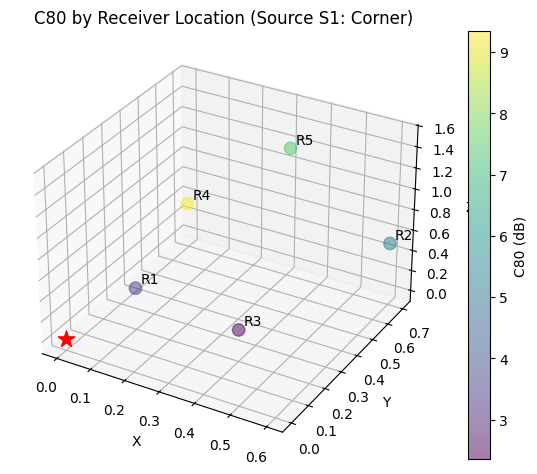

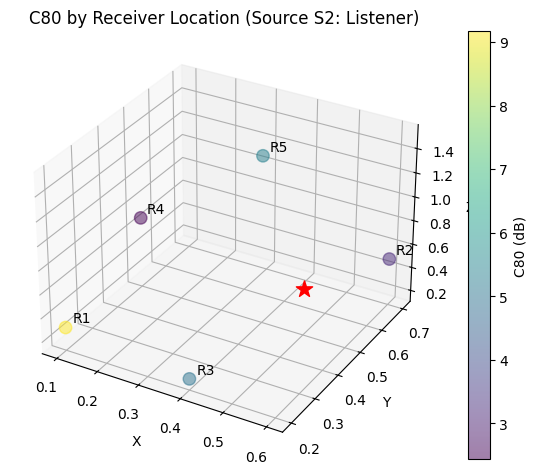

In [ ]:
# --- Separate C80 plots per source_id ---
for source_id, sub_collection in group_by_tag(collection, "source_id").items():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # get relevant meta data
    rec_locs = get_tags(sub_collection, "receiver_loc")
    rec_ids = get_tags(sub_collection, "receiver_id")
    c80s = get_tags(sub_collection, "c80")

    rx, ry, rz = zip(*rec_locs)
    sc = ax.scatter(rx, ry, rz, c=c80s, cmap="viridis", s=80, alpha=0.5)

    # add receiver labels separately
    for (x, y, z), rec_id in zip(rec_locs, rec_ids):
        ax.text(
            x + 0.01, y + 0.01, z + 0.01, str(rec_id), zorder=10, ma="left", va="bottom"
        )

    # mark the corresponding source
    if source_id in sources:
        ax.scatter(*sources[source_id], s=150, marker="*", color="red")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"C80 by Receiver Location (Source {source_id})")

    plt.colorbar(sc, label="C80 (dB)")
    plt.tight_layout()

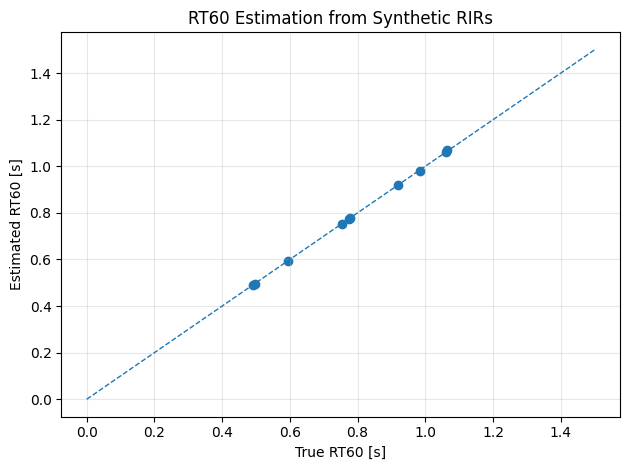

In [ ]:
RT60 = get_tags(collection, "rt60")
RT60_true = get_tags(collection, "rt60_true")

plt.figure()
plt.scatter(RT60_true, RT60)
plt.plot([0, 1.5], [0, 1.5], "--", lw=1)
plt.xlabel("True RT60 [s]")
plt.ylabel("Estimated RT60 [s]")
plt.title("RT60 Estimation from Synthetic RIRs")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()